# Coding Assignment 2

#### by Arnav Das (arnavmd2@uw.edu)

# Introduction to the Assignment  

In this assignment, you will build a model to **classify the sentiment of Yelp reviews**.

The **Yelp Reviews** dataset is a large collection of restaurant and business reviews written by users and annotated with **sentiment labels**.  
Each example contains a piece of review text along with a label indicating how positive or negative the reviewer’s experience was.

The goal is to **understand and categorize the sentiment expressed in each review** based solely on its text.

The labels correspond to different levels of sentiment:

#### 1-star — Strongly negative  
#### 2-star — Negative  
#### 3-star — Neutral  
#### 4-star — Positive  
#### 5-star — Strongly positive  

This dataset is widely used in **text classification and sentiment analysis**, making it a strong benchmark for evaluating how well models can interpret opinions, tone, and emotional content in written language.

# Part 1: Dataset Exploration (10 points)

Here we will do some quick sanity checks on the dataset, before we do any sort of training.

In [3]:
from datasets import load_dataset

SEED = 42
N_TRAIN = 50_000
N_VAL   = 5_000
N_EVAL  = 500

ds = load_dataset("yelp_review_full")
train_full = ds["train"].shuffle(seed=SEED)
train = train_full.select(range(N_TRAIN))
val   = train_full.select(range(N_TRAIN, N_TRAIN + N_VAL))

test = ds["test"].shuffle(seed=SEED).select(range(N_EVAL))

README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

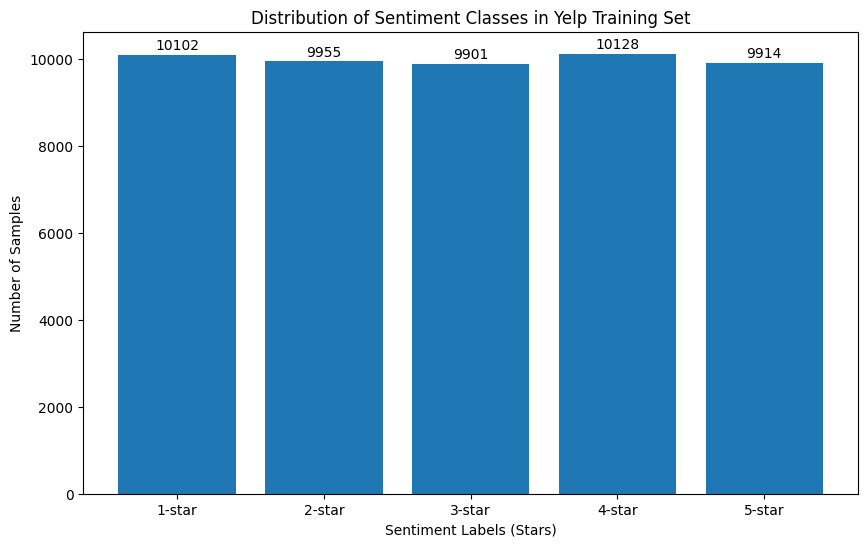

In [4]:
#TODO Put your code here (2.5 pts).
###########################################################################
# Plot a bar graph, that shows how many samples there are each class
import matplotlib.pyplot as plt
import pandas as pd


train_labels = train['label']
label_series = pd.Series(train_labels)
counts = label_series.value_counts().sort_index()
class_names = ['1-star', '2-star', '3-star', '4-star', '5-star']
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts)

plt.title('Distribution of Sentiment Classes in Yelp Training Set')
plt.xlabel('Sentiment Labels (Stars)')
plt.ylabel('Number of Samples')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom')

plt.show()


###########################################################################

# Part 3: BERT-Based Classification (50 points)

Now we use BERT as a feature extractor for classification.
We keep BERT frozen and train a small neural network on top of it to predict the labels.

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Function for tokenizing text
def manual_encode(text, max_length=512):
    """
    Encode a single Yelp review for BERT.
    Format: [CLS] text [SEP]
    """

    # Tokenize the text, and pad to max_length for collation
    tokens = tokenizer.tokenize(text)
    max_text_len = max_length - 2
    tokens = tokens[:max_text_len]
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    attention_mask = [1] * len(input_ids)

    # Pad to max_length
    padding_length = max_length - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }


In [8]:
def update_dataset(example):
    return manual_encode(example["text"])

train = train.map(update_dataset)
val  = val.map(update_dataset)
test  = test.map(update_dataset)


train = train.remove_columns(["text"])
val = val.remove_columns(["text"])
test  = test.remove_columns(["text"])

train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val, batch_size=32)
test_loader  = DataLoader(test, batch_size=32)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## **Part 4: Bakeoff (20 points)**

In this final section, you will take part in a friendly competition. You may use **any classifier of your choice** to generate predictions for a set of unlabeled examples.

Download the data from the Kaggle link:  https://www.kaggle.com/t/6f431e5fab1648e4a8af869a44405984

You are given two CSV files:

- `text.csv` — Contains two columns: an ID and the corresponding raw text. You must generate a prediction for each row.
- `sample_submission.csv` — Shows the required format for your submission file.

Once you have generated your predictions, submit them to the Kaggle competition using the above link.

In [9]:
import torch
from torch import nn
from transformers import BertModel

class BertSentimentClassifier(nn.Module):
    def __init__(self, num_labels=5):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # 2. p.requires_grad_(False)

        # 3. train
        self.classifier = nn.Linear(768, num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        return logits

In [10]:
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertSentimentClassifier(num_labels=5).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(1):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)

        loss = loss_fn(outputs, labels)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader)}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1 Loss: 0.8943870618262507


In [11]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

class PredictDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

df_new = pd.read_csv('text.csv')
predict_ds = PredictDataset(df_new['text'].tolist(), tokenizer)
predict_loader = DataLoader(predict_ds, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_preds = []
print("Fine Tune BERT predicting...")

with torch.no_grad():
    for batch in tqdm(predict_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        logits = model(input_ids, attention_mask)

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

submission = pd.DataFrame({
    'Id': df_new['Id'],
    'label': all_preds
})

submission.to_csv('submission_finetune.csv', index=False)
print("Finish: submission_finetune.csv")
print(submission.head())

Fine Tune BERT predicting...


  0%|          | 0/32 [00:00<?, ?it/s]

Finish: submission_finetune.csv
   Id  label
0   0      4
1   1      2
2   2      1
3   3      1
4   4      3
